Note to Self: Goal of this Notebook is to Generate Features for Cell Classification (Year, Piece ID, EI Time, EI Spectrogram, Axon Conduction Velocity, ACF Time, ACF Spectrogram, Estimated Soma from EI, and Centroid Location) and Verify Them using Visual Data

In [6]:
import importlib, os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
from icecream import ic

sys.path.append('../')
sys.path.append('/Volumes/Lab/Users/scooler/classification/')
sys.path.append("/Volumes/Lab/Users/mads/artificial-retina-software-pipeline/artificial-retina-software-pipeline/utilities/")
sys.path.append("/Volumes/Lab/Users/mads/cell_class/moosa_share/")

import cell_display_lib as cdl
import features as feat
import features_visual as feat_v
import features_electrical as feat_e
import deduplication

import features
import file_handling
from scipy.signal import spectrogram 
import scipy.signal as signal
import plotly.express as px
from sklearn.decomposition import PCA
# %load_ext autoreload
# %autoreload 2
import visionloader as vl
from conduction_velocity_code import get_axonal_conduction_velocity, upsample_ei, filter_ei_for_electrode_types
from scipy import stats
import eilib as el
import math
from skimage import measure
from cell_display_lib import show
import cv2

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'

print('modules loaded! GO TIME')

# Your custom parameters
load_file = False
save_file = True
save_name = 'featExtract_v1'  # customize this!
scratch_file_root = '/Volumes/Scratch/Users/mads/celltable_datasets/' # replace my name!

modules loaded! GO TIME


/tmp/ipykernel_46998/3874339880.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [5]:
# Or you could skip down to here and just load
scratch_file_root = '/Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/'
save_name = 'test0to15'

load_file = 1
if load_file:
    importlib.reload(cdl)
    ct = cdl.CellTable()
    # pieces = piece_run.keys()
    ct.file_load_pieces(pieces=None, file_root=scratch_file_root, save_name = save_name, process_labels=True)

~ Welcome to the CellTable ~experience~
~ 
~ Starting a fresh new CellTable
~ Loading and overwriting entire datasets table for per-dataset file loading
~ Loading 15 pieces from /Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/
*** timer  started
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Volumes/Lab/Development/miniconda-peggyo/envs/mads3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_46998/1705537420.py", line 10, in <cell line: 6>
    ct.file_load_pieces(pieces=None, file_root=scratch_file_root, save_name = save_name, process_labels=True)
  File "/Volumes/Lab/Users/scooler/classification/cell_display_lib.py", line 551, in file_load_pieces
    self.dataset_table = pd.concat([self.dataset_table, datasets], verify_integrity=True)
  File "/Volumes/Lab/Development/miniconda-peggyo/envs/mads3/lib/python3.9/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/Volumes/Lab/Development/miniconda-peggyo/envs/mads3/lib/python3.9/site-packages/pandas/core/reshape/concat.py", line 347, in concat
    op = _Concatenator(
  File "/Volumes/Lab/Development/miniconda-peggyo/env

In [7]:
# The dataset_table holds information about the datasets we want to work with, both their input properties (path)
# and their analysis (retinal location, etc). First we make it outside the CellTable, then we let the CellTable
# hold it and take over

# I'm using a utility function here to make this table, but you can use a wide variety of ways to build it
# You may want to customize the path, in which case you can use this function then load those afterward

piece_run = {'2018-03-01-0': '000','2017-03-15-1': '000'}
print(f'Setting up {len(piece_run)} pieces')

index = []
dataset_dict = cdl.new_dataset_dict()
sorter_name = 'kilosort'
for piece_id, run_id in piece_run.items():
    path = f'/Volumes/Analysis/{piece_id}/kilosort_data{run_id}/data{run_id}/'
    if not os.path.isdir(path):
        print(f'Missing main vision analysis data {path}')
        continue

    label_mode, label_data_path, sta_path, ei_path = cdl.make_paths(piece_id, run_id)
    dataset_dict['run_id'].append(run_id)
    dataset_dict['piece_id'].append(piece_id)
    dataset_dict['note'].append('novel')
    dataset_dict['path'].append(path)
    dataset_dict['labels'].append(label_mode)
    dataset_dict['sorter'].append('kilosort')
    dataset_dict['label_data_path'].append(label_data_path)
    dataset_dict['sta_path'].append(sta_path)
    dataset_dict['ei_path'].append(ei_path)
    dataset_dict['stimulus_type'].append('whitenoise')
    dataset_dict['species'].append('macaque')
    index.append((piece_id, run_id))
dataset_table = pd.DataFrame(dataset_dict, index=pd.MultiIndex.from_tuples(index, names=['piece_id','run_id']))

display(dataset_table)

Setting up 2 pieces


,,run_id,sorter,labels,piece_id,path,note,label_data_path,sta_path,ei_path,stimulus_type,species
piece_id,run_id,,,,,,,,,,,
2018-03-01-0,000,000,kilosort,alexandra,2018-03-01-0,/Volumes/Analysis/2018-03-01-0/kilosort_data00...,novel,/Volumes/Scratch/Users/alexth/all_data/2018-03...,/Volumes/Scratch/Users/alexth/supersample-stas...,/Volumes/Scratch/Users/alexth/supersample-stas...,whitenoise,macaque
2017-03-15-1,000,000,kilosort,alexandra,2017-03-15-1,/Volumes/Analysis/2017-03-15-1/kilosort_data00...,novel,/Volumes/Scratch/Users/alexth/all_data/2017-03...,/Volumes/Scratch/Users/alexth/supersample-stas...,/Volumes/Scratch/Users/alexth/supersample-stas...,whitenoise,macaque


In [8]:
# The CellTable lives in Cell Display Lib, a module full of functions that are useful for cell data handling

importlib.reload(cdl)
ct = cdl.CellTable()  # Initialize the core object, called the CellTable spelled 'ct'



~ Welcome to the CellTable ~experience~
~ 
~ Starting a fresh new CellTable


In [9]:
# load the dataset_table we created into the ct
dataset_ids = ct.add_datasets(dataset_table)

# let's explore those dataset_ids.
# The ct internal tables have pandas MultiIndexes as their indexes, so you use tuples to access individual rows
# for the datasets, the tuples are ('piece_id','run_id')
print(dataset_ids[0])
display(ct.dataset_table.loc[('2018-03-01-0','000')])

~ Adding 2 datasets
('2018-03-01-0', '000')


run_id                                                           000
sorter                                                      kilosort
labels                                                     alexandra
piece_id                                                2018-03-01-0
path               /Volumes/Analysis/2018-03-01-0/kilosort_data00...
note                                                           novel
label_data_path    /Volumes/Scratch/Users/alexth/all_data/2018-03...
sta_path           /Volumes/Scratch/Users/alexth/supersample-stas...
ei_path            /Volumes/Scratch/Users/alexth/supersample-stas...
stimulus_type                                             whitenoise
species                                                      macaque
Name: (2018-03-01-0, 000), dtype: object

In [10]:
ct.initialize_units_for_datasets(dataset_ids)

# let's look at the unit_table, where most of the analysis is stored, which we have just filled with one row for every unit.
# Each unit is also indexed by a tuple: ('piece_id','run_id','unit_id'), the last of which is the familiar Vision ID,
# the output from the spike sorter. Note that these are not consecutive, but might be arranged on the electrode array.
# the table also has columns 'unit_id' and 'dataset_id' for easy access later and to keep things organized
# the column 'valid' is for excluding cells with basic errors, like having no spikes
display(ct.unit_table)

~ Loading new units from MultiIndex([('2018-03-01-0', '000'),
            ('2017-03-15-1', '000')],
           names=['piece_id', 'run_id']), currently have 2 datasets
~ Starting with unit_table having 0 units
~ Dataset ('2018-03-01-0', '000'): Loaded 1160 units, sorter/alex indices 1 through 1669
~ Dataset ('2017-03-15-1', '000'): Loaded 835 units, sorter/alex indices 1 through 1150
~ done with dataset setup, now have 2 datasets, 1995 units


unit_id           dataset_id run_id  \
piece_id     run_id unit_id                                        
2017-03-15-1 000    1              1  (2017-03-15-1, 000)    000   
                    4              4  (2017-03-15-1, 000)    000   
                    5              5  (2017-03-15-1, 000)    000   
                    6              6  (2017-03-15-1, 000)    000   
                    7              7  (2017-03-15-1, 000)    000   
...                              ...                  ...    ...   
2018-03-01-0 000    1665        1665  (2018-03-01-0, 000)    000   
                    1666        1666  (2018-03-01-0, 000)    000   
                    1667        1667  (2018-03-01-0, 000)    000   
                    1668        1668  (2018-03-01-0, 000)    000   
                    1669        1669  (2018-03-01-0, 000)    000   

                                 piece_id  valid  
piece_id     run_id unit_id                       
2017-03-15-1 000    1        2017-03-15-1   True  
                    4        2017-03-15-1   True  
                    5        2017-03-15-1   True  
                    6        2017-03-15-1   True  
                    7        2017-03-15-1   True  
...                                   ...    ...  
2018-03-01-0 000    1665     2018-03-01-0   True  
                    1666     2018-03-01-0   True  
                    1667     2018-03-01-0   True  
                    1668     2018-03-01-0   True  
                    1669     2018-03-01-0   True  

[1995 rows x 5 columns]

In [11]:
# Features are how we generate the parameters that each cell has, which we use for analysis.
# We'll make our own feature in a later section

# a list of all of the features we want to run per-dataset
# each of these are subclasses of Feature
features_to_generate_by_dataset = [
    feat.Feature_load_manual_labels,
    feat.Feature_load_dataset_metadata,

    # electrical
    feat_e.Feature_load_spike_times, feat_e.Feature_spikes_basic,
    feat_e.Feature_load_acf,  feat_e.Feature_load_ei,
    feat_e.Feature_generate_acf_from_spikes,
    feat_e.Feature_spike_waveform,
    feat_e.Feature_ei_correlation_data,
    feat_e.Feature_ei_select_electrodes, feat_e.Feature_ei_map,

    # visual
    feat_v.Feature_load_sta,
    feat_v.Feature_sta_basic,
    feat_v.Feature_sigstix, feat_v.Feature_primary_colors, feat_v.Feature_timecourses, feat_v.Feature_center_of_mass,
    feat_v.Feature_rf_map,  feat_v.Feature_rf_advanced_properties,
    feat_v.Feature_rf_histogram,
    feat_v.Feature_edge_detection
]

# and then one feature to run overall, which sorts out the manual labels from text into integers
features_to_generate_overall = [feat.Feature_process_manual_labels]

# if the ct is very large we'll drop the big columns like STA and EI to save disk space, as they can be
# easily reloaded later as needed
drop_big_columns = ct.unit_table.shape[0] > 10000
# Removed 'ei' from big_columns_per_dataset b/c will likely use
big_columns_per_dataset = ['sta']

# now generate the features we listed above, and display the resulting units_table
# check out all of those new columns, which you can use to make your analysis
ct.generate_features('all', features_to_generate_by_dataset, features_to_generate_overall,
                     force_features=False,
                     load_analysis_data=True,
                     ignore_errors=False,
                     drop_big_columns=False,
                     big_columns_per_dataset=big_columns_per_dataset)
display(ct.unit_table)

~ Activating per-dataset features ["<class 'features.Feature_load_manual_labels'>", "<class 'features.Feature_load_dataset_metadata'>", "<class 'features_electrical.Feature_load_spike_times'>", "<class 'features_electrical.Feature_spikes_basic'>", "<class 'features_electrical.Feature_load_acf'>", "<class 'features_electrical.Feature_load_ei'>", "<class 'features_electrical.Feature_generate_acf_from_spikes'>", "<class 'features_electrical.Feature_spike_waveform'>", "<class 'features_electrical.Feature_ei_correlation_data'>", "<class 'features_electrical.Feature_ei_select_electrodes'>", "<class 'features_electrical.Feature_ei_map'>", "<class 'features_visual.Feature_load_sta'>", "<class 'features_visual.Feature_sta_basic'>", "<class 'features_visual.Feature_sigstix'>", "<class 'features_visual.Feature_primary_colors'>", "<class 'features_visual.Feature_timecourses'>", "<class 'features_visual.Feature_center_of_mass'>", "<class 'features_visual.Feature_rf_map'>", "<class 'features_visual.

unit_id           dataset_id run_id  \
piece_id     run_id unit_id                                        
2017-03-15-1 000    1              1  (2017-03-15-1, 000)    000   
                    4              4  (2017-03-15-1, 000)    000   
                    5              5  (2017-03-15-1, 000)    000   
                    6              6  (2017-03-15-1, 000)    000   
                    7              7  (2017-03-15-1, 000)    000   
...                              ...                  ...    ...   
2018-03-01-0 000    1665        1665  (2018-03-01-0, 000)    000   
                    1666        1666  (2018-03-01-0, 000)    000   
                    1667        1667  (2018-03-01-0, 000)    000   
                    1668        1668  (2018-03-01-0, 000)    000   
                    1669        1669  (2018-03-01-0, 000)    000   

                                 piece_id  valid label_manual_text_input  \
piece_id     run_id unit_id                                                
2017-03-15-1 000    1        2017-03-15-1   True              OFF midget   
                    4        2017-03-15-1   True               ON midget   
                    5        2017-03-15-1   True              OFF midget   
                    6        2017-03-15-1   True              ON parasol   
                    7        2017-03-15-1   True                     NaN   
...                                   ...    ...                     ...   
2018-03-01-0 000    1665     2018-03-01-0   True                    edge   
                    1666     2018-03-01-0   True                    edge   
                    1667     2018-03-01-0   True                    edge   
                    1668     2018-03-01-0   True              ON parasol   
                    1669     2018-03-01-0   True             OFF parasol   

                             alex_id spike_times  spike_count  spike_duration  \
piece_id     run_id unit_id                                                     
2017-03-15-1 000    1            0.0       a4550       4550.0      1797.35910   
                    4            1.0       a6743       6743.0      1799.72895   
                    5            2.0       a2876       2876.0      1796.27165   
                    6            3.0       a5747       5747.0      1799.87180   
                    7            NaN         a42         42.0      1712.65550   
...                              ...         ...          ...             ...   
2018-03-01-0 000    1665       909.0       a5845       5845.0      1799.67995   
                    1666       910.0       a1744       1744.0      1799.72620   
                    1667       219.0       a6145       6145.0      1799.95705   
                    1668       165.0       a5233       5233.0      1799.44105   
                    1669       131.0       a2060       2060.0      1796.87245   

                             ...  rf_noise_level rf_threshold rf_size  \
piece_id     run_id unit_id  ...                                        
2017-03-15-1 000    1        ...              a6           a6      a7   
                    4        ...              a6           a6      a7   
                    5        ...              a6           a6      a7   
                    6        ...              a6           a6      a7   
                    7        ...              a6           a6      a7   
...                          ...             ...          ...     ...   
2018-03-01-0 000    1665     ...              a6           a6      a7   
                    1666     ...              a6           a6      a7   
                    1667     ...              a6           a6      a7   
                    1668     ...              a6           a6      a7   
                    1669     ...              a6           a6      a7   

                            rf_num_islands rf_solidity rf_size_hull  \
piece_id     run_id unit_id                                           
2017-03-1

In [12]:
# ct.cell_table contains just the true unique cells in each piece, with integer indices
# the CellTable has a decent deduplication algorithm implemented, which combines multiple units into single cells
# if you don't care for deduplication, just don't run it. You will still need to initialize_cell_table though,
# and you'll have one cell per unit.

ct.initialize_cell_table()
deduplication.deduplicate(ct, use_sta=False, do_combine_unit_data=False, verbose=False)

display(ct.cell_table)

Piece 2018-03-01-0 has 1160 units from 1 datasets
Piece 2017-03-15-1 has 835 units from 1 datasets
~ Created fresh new cell_table and reset unit_table links. Now, you may deduplicate.
Deduplicating units into cells.
~ Correlating EI between units
*** timer  started

Evaluating piece 2018-03-01-0 w/ 1 datasets, 1160 units
Map dim 512, wave dim 201. Correlating EI energy first.
Correlating spike waveforms.
~ ... piece 2018-03-01-0, correlated EI maps & spike waveforms from 1160 units.
*** elapsed 4s of 4s = 0.1m elapsed, of 0.1m estimated (1/2) (0.2 / sec)

Evaluating piece 2017-03-15-1 w/ 1 datasets, 835 units
Map dim 512, wave dim 201. Correlating EI energy first.
Correlating spike waveforms.
~ ... piece 2017-03-15-1, correlated EI maps & spike waveforms from 835 units.
*** elapsed 2s of 6s = 0.1m elapsed, of 0.1m estimated (2/2) (0.3 / sec)
~ found 32139 NaN EI correlations
~ Done. Calculated 1020415 EI & ACF correlations
~ Applying heuristic to 1020415 correlations...
~ Done. Found 7

unit_ids  \
piece_id     cell_id                                                      
2018-03-01-0 0                                ((2018-03-01-0, 000, 1),)   
             1                                ((2018-03-01-0, 000, 3),)   
             2                                ((2018-03-01-0, 000, 4),)   
             3                               ((2018-03-01-0, 000, 10),)   
             4                               ((2018-03-01-0, 000, 11),)   
...                                                                 ...   
2017-03-15-1 594      ((2017-03-15-1, 000, 1146), (2017-03-15-1, 000...   
             595      ((2017-03-15-1, 000, 25), (2017-03-15-1, 000, ...   
             596      ((2017-03-15-1, 000, 197), (2017-03-15-1, 000,...   
             597      ((2017-03-15-1, 000, 1149), (2017-03-15-1, 000...   
             598      ((2017-03-15-1, 000, 1150), (2017-03-15-1, 000...   

                                                        unit_ids_by_run  \
piece_id     cell_id                                                      
2018-03-01-0 0                   {'000': (('2018-03-01-0', '000', 1),)}   
             1                   {'000': (('2018-03-01-0', '000', 3),)}   
             2                   {'000': (('2018-03-01-0', '000', 4),)}   
             3                  {'000': (('2018-03-01-0', '000', 10),)}   
             4                  {'000': (('2018-03-01-0', '000', 11),)}   
...                                                                 ...   
2017-03-15-1 594      {'000': [('2017-03-15-1', '000', 535), ('2017-...   
             595      {'000': [('2017-03-15-1', '000', 25), ('2017-0...   
             596      {'000': [('2017-03-15-1', '000', 45), ('2017-0...   
             597      {'000': [('2017-03-15-1', '000', 871), ('2017-...   
             598      {'000': [('2017-03-15-1', '000', 843), ('2017-...   

                     unit_ids_wn  unit_id_wn_combined unit_id_nsem  \
piece_id     cell_id                                                 
2018-03-01-0 0                ()                  NaN          NaN   
             1                ()                  NaN          NaN   
             2                ()                  NaN          NaN   
             3                ()                  NaN          NaN   
             4                ()                  NaN          NaN   
...                          ...                  ...          ...   
2017-03-15-1 594              ()                  NaN          NaN   
             595              ()                  NaN          NaN   
             596              ()                  NaN          NaN   
             597              ()                  NaN          NaN   
             598              ()                  NaN          NaN   

                                                      corr_included  \
piece_id     cell_id                                                  
2018-03-01-0 0                                                   []   
             1                                                   []   
             2                                                   []   
             3                                                   []   
             4                                                   []   
...                                                             ...   
2017-03-15-1 594                                          [1016629]   
             595      [1017105, 1017189, 1017352, 1017765, 1017878]   
             596                                 [1017949, 1018061]   
             597                        [1019186, 1019288, 1019378]   
             598      [1020036, 1020137, 1020189, 1020196, 1020245]   

                      label_manual label_manual_text      piece_id  \
piece_id     cell_id                                                 
2018-03-01-0 0                23.0         ON midget  2018-03-01-0   
             1                35.0               NaN  2018-03-01-0

In [20]:
pd.options.display.max_rows = 4000
# let's select some ON parasols from the first dataset
# indices = ct.cell_selection(types=['ON parasol'], pieces=['2018-03-01-0'])
indices = ct.cell_selection(types=['ON parasol'])

# we could also get the first dataset from the table index and use that:
# dataset_id = ct.dataset_table.index[0]
# indices = ct.cell_selection(types=['ON parasol'], pieces=[dataset_id])


# either way, we now have all of the cells we want
# Let's grab the first one and see what it has in there
id = indices[0]
print(id) # see the piece_id, cell_id
cell = ct.get_cell(id)
print(cell['piece_id'])
print(cell)

# lots of things in there!
# column names are on the left, values are on the right.
# a value starting with 'a' is an array, the following integers are the dimensions.

# Let's plot the ACF:

# plt.figure()
# plt.plot(cell['tc'].a)
# plt.show()

# NOTE!!! you see that '.a' up there? That's important. To ease storing arrays and dicts in pandas
# dataframes, we store them inside a wrapper object, defined in file_handling.wrapper
# to access the data, just add .a to the end. That wrapper is what generates those 'a40x20x6' strings you saw.

('2018-03-01-0', 7)
2018-03-01-0
unit_id                                                                       16
dataset_id                                                   (2018-03-01-0, 000)
run_id                                                                       000
piece_id                                                            2018-03-01-0
valid                                                                       True
label_manual_text_input                                               ON parasol
alex_id                                                                      7.0
spike_times                                                                a6922
spike_count                                                               6922.0
spike_duration                                                        1799.95205
spike_rate_mean                                                         3.845658
acf                                                                         

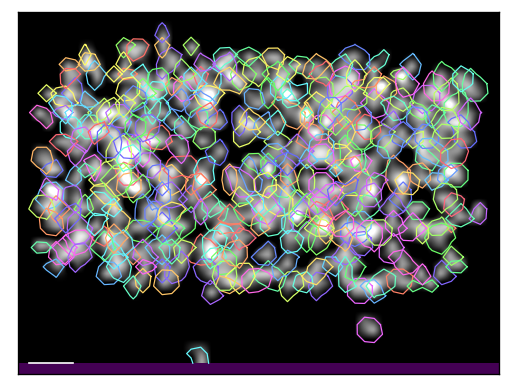

In [20]:
# okay, so let's check out the figures we can make. A mosaic of all of the OFF parasols
indices = ct.cell_selection(types=['OFF midget'], pieces=[0])

ct.show_mosaic(indices, color_channels=cdl.channelize(['green OFF']), threshold_multiplier=2)
# tune the threshold_multiplier to get the RF sizes you like. Each cell is affected together

~ Analyzing & plotting 4 cells
~ Display colors pc0 OFF
~ Cell 2018-03-01-0:c4u11, type m:OFF midget
~ Cell 2018-03-01-0:c5u12, type m:OFF midget
~ Cell 2018-03-01-0:c6u13, type m:OFF midget
~ Cell 2018-03-01-0:c9u18, type m:OFF midget


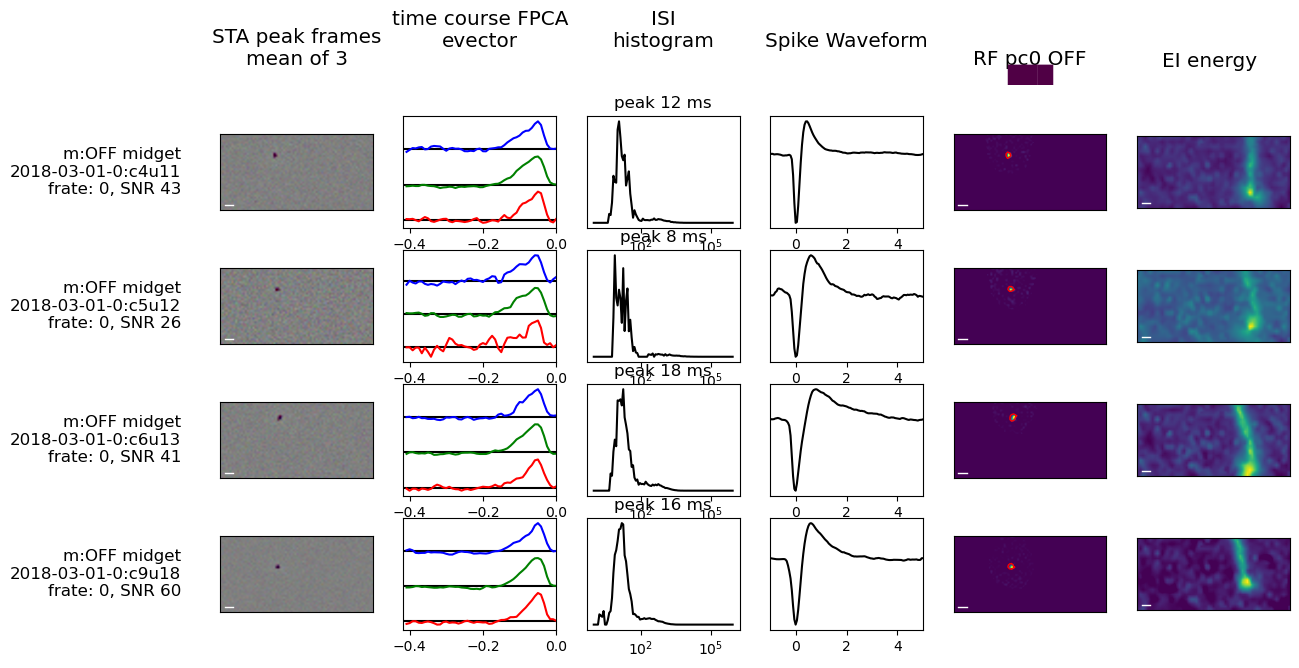

In [21]:
# Let's drill down and see what some of those OFF parasols are doing

# plots = ['rf_maps', 'time_courses', 'acf','ei_map']
plots = ['rf_maps','time_courses', 'acf','ei_map', 'ei_contours_on_sta','spike_waveform']
fig, axs = ct.show_cell_grid(indices[:4], plots=plots,
                             color_channels=cdl.channelize(['green OFF']), zoom_span=1000,
                             enable_zoom=False)



2018-03-01-0  314            crap
              21             edge
              887            crap
              471      OFF smooth
              635       OFF PAC 3
              663              A1
              508    contaminated
              333             NaN
              443    contaminated
              295            crap
Name: label_manual_text, dtype: object
~ Analyzing & plotting 8 cells
~ Display colors pc0 ON, pc0 OFF, pc1 ON
~ Cell 2018-03-01-0:c935u68, type m:ON parasol
~ Cell 2018-03-01-0:c781u1364, type m:OFF parasol
~ Cell 2018-03-01-0:c279u489, type m:SBC
~ Cell 2018-03-01-0:c492u858, type m:nan
~ Cell 2018-03-01-0:c723u1271, type m:contaminated
~ Cell 2018-03-01-0:c248u430, type m:OFF PAC 3
~ Cell 2018-03-01-0:c600u1056, type m:nan
~ Cell 2018-03-01-0:c278u385, type m:edge


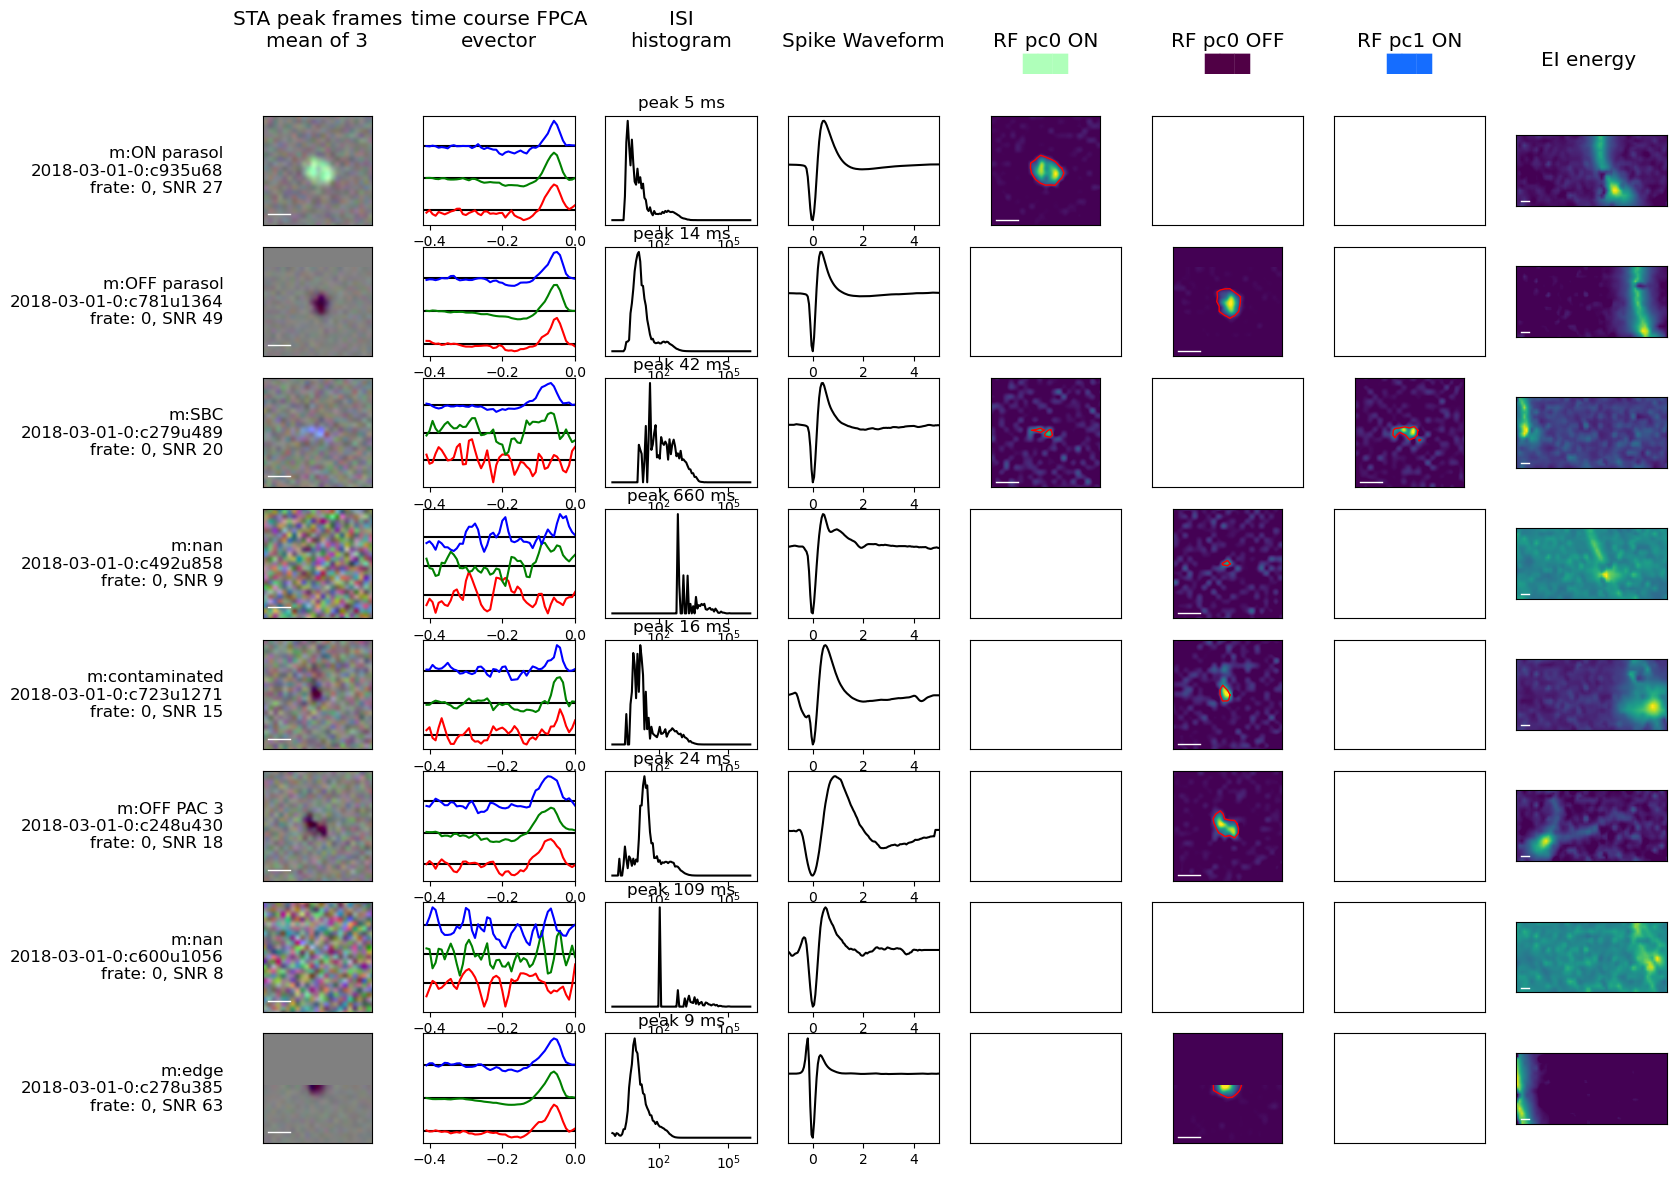

In [11]:
# let's say we're developing some new feature, and want to see how it works on all cells,
# not just the big five. This function will select random non-bigfive cells for us. I select out the label_manual_text, which is
# where the 'cell type' can be found:
indices = ct.cell_selection_examples(pieces=[0], count_random=10)
print(ct.get_cells(indices).label_manual_text)

# or 2 of each of a few types:
indices = ct.cell_selection_examples(pieces=[0],
                                     count_random=5,
                                     types=['ON parasol','OFF parasol','SBC'],
                                     count_each_type=1,
                                     random_exclude_common_types=True)
fig, axs = ct.show_cell_grid(indices, plots=plots,
                  color_channels=cdl.channelize(['green ON','green OFF','blue ON']),
                  zoom_span=1000)

In [12]:
# now let's stack together all of the green TCs of four types in a dataset, ignore the edge cells,
# run a PCA, and see if they segregate
# note that the TCs here are all positive-peak, so they don't encode cell polarity

indices_unfiltered = ct.cell_selection(types=['ON parasol','ON midget','OFF parasol','OFF midget'], datasets=[0])
cells = ct.get_cells(indices_unfiltered)
central = np.logical_not(cells.sta_edge.astype(bool))
indices = indices_unfiltered[central]
cells = ct.get_cells(indices)
spec_spike_waveforms = np.stack([spec_spike_waveform.a for spec_spike_waveform in cells['spec_spike_waveform']]) # the 1 there is for green, as in RGB
print(spec_spike_waveforms.shape)
# plt.figure(figsize=[4,4]) # if you want to look at the timecourses all together
# plt.plot(tcs.T)
# plt.show()

projections = PCA(n_components=2).fit_transform(spec_spike_waveforms[:,:,0])
fig = px.scatter(projections, x=0, y=1, color=cells.label_manual_text, hover_name=cells.index.to_numpy())
fig.update_layout({'title': 'PCA example', 'xaxis_title':'PC0', 'yaxis_title':'PC1'})
fig.show()

# looks like they do! But you knew that.
# I recommend using px.scatter for its interactivity and easy plotting by types. Hover over the plot and you
# can see the cell_id for each point, and box select to zoom in.

KeyError: 'spec_spike_waveform'

('2018-03-01-0', 26)


/tmp/ipykernel_46998/3102584945.py:45: UserWarning: Only one segment is calculated since parameter NFFT (=100) >= signal length (=100).
  spec, f, t, im = plt.specgram(wave, Fs=fs, NFFT = n, noverlap=np.ceil(n/2))


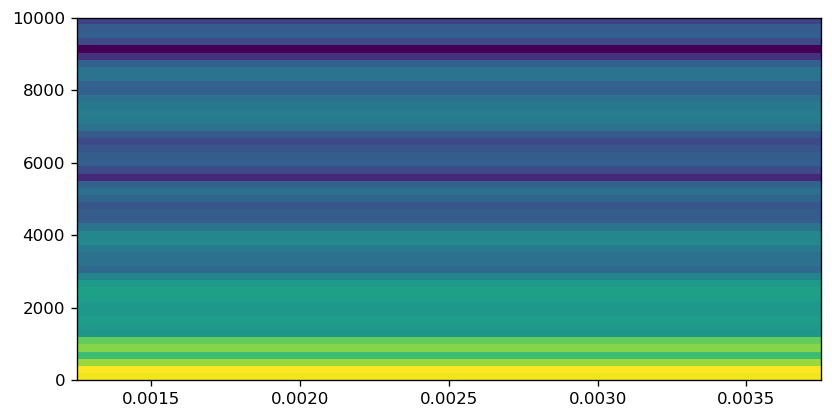

In [49]:
# Examples of Features
indices = ct.cell_selection(types=['ON parasol'])
id = indices[1]
print(id) # see the piece_id, cell_id
cell = ct.get_cell(id)

# Plot Spike Waveform
# plots = [ 'acf','ei_map','spike_waveform']
# plt.figure(1)
# fig, axs = ct.show_cell_grid(indices[1:2], plots=plots,
#                              zoom_span=1000,
#                              enable_zoom=False)

# EI Contours
# ei_energy = cell['map_ei_energy_early'].a
# ei_energy = np.flip(ei_energy)
# thresholds = (np.percentile(ei_energy,90), np.percentile(ei_energy,99.8))
# ei_energy = np.flip(ei_energy)
# segments_all_ei = [measure.find_contours(ei_energy, level = thresholds[i]) for i in range(len(thresholds))]
# color_by_threshold = ['white', 'red']
# plt.figure(2)
# show(ei_energy,[-1,np.max(ei_energy)],None,interpolation='bilinear')
# plt.xticks([])
# plt.yticks([])
# calib_length = 100 * (ei_energy.shape[1] / 900)
# plt.plot([2,calib_length+2],[2,2],linestyle='-',color='white',linewidth=1)
# for ssi, segments in enumerate(segments_all_ei):
#     for si, seg in enumerate(segments):
#         ## Set up for cv2
#         seg_proc = []
#         for point in seg:
#             point_proc = [int(point[0]), int(point[1])]
#             seg_proc.append([point_proc])
#         seg_proc = np.array(seg_proc)
        
#         plt.plot(seg[:,0],seg[:,1], color_by_threshold[ssi],linewidth=1)

# Power Spectograms
wave = cell['acf'].a
t_wave = np.arange(len(wave)) / 20 - 5
t_wave = t_wave / 1000
fs = 20000
n = min(256,len(wave))

spec, f, t, im = plt.specgram(wave, Fs=fs, NFFT = n, noverlap=np.ceil(n/2))


('2018-03-01-0', 7)
~ Analyzing & plotting 1 cells
~ Display colors pc0 ON, pc0 OFF, pc1 ON
~ Cell 2018-03-01-0:c7u16, type m:ON parasol
449.79565 418.47427 0.9303653 47 102 8652.795 8381.086 7758.975036621094 8096.32177734375 19.556332795516305 18.741485595703125 34228.406


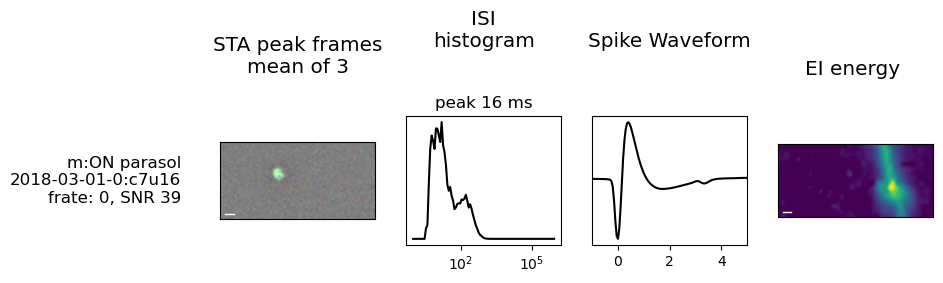

In [108]:
# Test Feature Caluclation on Single Cell Here
indices = ct.cell_selection(types=['ON parasol'])
id = indices[0]
print(id) # see the piece_id, cell_id
cell = ct.get_cell(id)


spike_wave = cell['spike_waveform_maxamplitude'].a

plots = [ 'acf','ei_map','spike_waveform']
fig, axs = ct.show_cell_grid(indices[0:1], plots=plots,
                             zoom_span=1000,
                             enable_zoom=False)

spike_wave = signal.resample(spike_wave, len(spike_wave)*10)
h = np.abs(np.min(spike_wave))
l = np.abs(np.max(spike_wave))
l_h_ratio = np.abs(np.max(spike_wave)/np.min(spike_wave))
amp_idx = np.argmin(spike_wave)
lower_idx = amp_idx
upper_idx = amp_idx
while(spike_wave[lower_idx] < spike_wave[amp_idx]/2):
    if(lower_idx == 0):
        break
    lower_idx = lower_idx -1
while(spike_wave[upper_idx] < spike_wave[amp_idx]/2):
    if(upper_idx == len(spike_wave)-1):
        break
    upper_idx = upper_idx +1
width_half_min_amp = upper_idx - lower_idx
area_amp_upper = np.abs(np.sum([spike_wave[idx] for idx in range(amp_idx,upper_idx)]))
area_amp_lower = np.abs(np.sum([spike_wave[idx] for idx in range(lower_idx+1,amp_idx)]))
area_tr_amp_upper = h*(3/4)*(upper_idx-amp_idx)
area_tr_amp_lower = h*(3/4)*(amp_idx-lower_idx)
slope_amp_upper = h / (upper_idx-amp_idx)
slope_amp_lower = h / (amp_idx-lower_idx)

amp_idx = np.argmax(spike_wave)
upper_idx_max = amp_idx
lower_idx_max = amp_idx
while(spike_wave[lower_idx_max] > spike_wave[amp_idx]/2):
    if(lower_idx_max==0):
        break
    lower_idx_max = lower_idx_max -1
while(spike_wave[upper_idx_max] > spike_wave[amp_idx]/2):
    if(upper_idx_max == len(spike_wave)-1):
        break
    upper_idx_max = upper_idx_max +1
area2 = np.sum([spike_wave[idx] for idx in range(lower_idx_max+1,upper_idx_max)])
width_half_max_amp = upper_idx_max - lower_idx_max

print(h,l,l_h_ratio,width_half_min_amp,width_half_max_amp,area_amp_upper,area_amp_lower,area_tr_amp_upper,area_tr_amp_lower,slope_amp_upper,slope_amp_lower, area2)



In [109]:
# Test Feature Caluclation on Multiple Cells Here
indices = ct.cell_selection_examples(types=['ON parasol','ON midget','OFF midget', 'OFF parasol', 'SBC'], count_each_type=1, datasets=[1])


for ind in indices:
    # print(ind)
    cell = ct.get_cell(ind)
    
    spike_wave = cell['spike_waveform_maxamplitude'].a
    spike_wave = signal.resample(spike_wave, len(spike_wave)*10)
    h = np.abs(np.min(spike_wave))
    l = np.abs(np.max(spike_wave))
    l_h_ratio = np.abs(np.max(spike_wave)/np.min(spike_wave))
    amp_idx = np.argmin(spike_wave)
    lower_idx = amp_idx
    upper_idx = amp_idx
    while(spike_wave[lower_idx] < spike_wave[amp_idx]/2):
        if(lower_idx == 0):
            break
        lower_idx = lower_idx -1
    while(spike_wave[upper_idx] < spike_wave[amp_idx]/2):
        if(upper_idx == len(spike_wave)-1):
            break
        upper_idx = upper_idx +1
    width_half_min_amp = upper_idx - lower_idx
    area_amp_upper = np.abs(np.sum([spike_wave[idx] for idx in range(amp_idx,upper_idx)]))
    area_amp_lower = np.abs(np.sum([spike_wave[idx] for idx in range(lower_idx+1,amp_idx)]))
    area_tr_amp_upper = h*(3/4)*(upper_idx-amp_idx)
    area_tr_amp_lower = h*(3/4)*(amp_idx-lower_idx)
    slope_amp_upper = h / (upper_idx-amp_idx)
    slope_amp_lower = h / (amp_idx-lower_idx)

    amp_idx = np.argmax(spike_wave)
    upper_idx_max = amp_idx
    lower_idx_max = amp_idx
    while(spike_wave[lower_idx_max] > spike_wave[amp_idx]/2):
        if(lower_idx_max==0):
            break
        lower_idx_max = lower_idx_max -1
    while(spike_wave[upper_idx_max] > spike_wave[amp_idx]/2):
        if(upper_idx_max == len(spike_wave)-1):
            break
        upper_idx_max = upper_idx_max +1
    area2 = np.sum([spike_wave[idx] for idx in range(lower_idx_max+1,upper_idx_max)])
    width_half_max_amp = upper_idx_max - lower_idx_max

    print(h,l,l_h_ratio,width_half_min_amp,width_half_max_amp,area_amp_upper,area_amp_lower,area_tr_amp_upper,area_tr_amp_lower,slope_amp_upper,slope_amp_lower, area2)







367.90033 303.90564 0.8260543 38 88 5753.465 5451.3784 5242.579696655273 5242.579696655273 19.363175241570723 19.363175241570723 21274.924
461.07455 259.99026 0.563879 69 138 11080.647 14880.786 10028.371559143066 13832.236633300781 15.899122567012393 11.526863861083985 27431.305
75.69113 38.162098 0.5041819 53 140 1665.2306 1553.165 1532.7454147338867 1475.977066040039 2.803375244140625 2.9111973689152646 4111.338
146.6829 88.65517 0.6044001 49 111 2902.697 2874.0156 2640.2923278808594 2750.3045082092285 6.111787796020508 5.8673162841796875 7831.7373
159.1575 52.524307 0.33001465 61 27 4590.7715 3177.4634 4297.252532958984 2984.2031478881836 4.421041700575087 6.366300048828125 1109.8804


## FEATURE: Spike Waveform Characteristics

In [22]:
# Takes a min to run, put in print countdown in future updates
# Comes from EI_time_waveform_analysis_train.ipynb 
class Feature_spike_char(features.Feature):
    name = 'spike_char'
    requires = {'unit':{'spike_waveform_maxamplitude'}}
    provides = {'unit':{'spike_min_h','spike_max_l','spike_minmax_ratio','spike_width_half_min_amp','spike_width_half_max_amp','spike_area_amp_upper','spike_area_amp_lower','spike_area_tr_amp_upper','spike_area_tr_amp_lower','spike_slope_amp_upper','spike_slope_amp_lower', 'spike_area2'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Maddy' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return
        
        spike_min_h = []
        spike_max_l = []
        spike_minmax_ratio = []
        spike_width_half_min_amp = []
        spike_width_half_max_amp = []
        spike_area_amp_upper = []
        spike_area_amp_lower = []
        spike_area_tr_amp_upper = []
        spike_area_tr_amp_lower = []
        spike_slope_amp_upper = []
        spike_slope_amp_lower = []
        spike_area2 = []

        for ci in unit_indices:
            spike_wave = dtab.at[ci,'spike_waveform_maxamplitude'].a
            spike_wave = signal.resample(spike_wave, len(spike_wave)*10)
            
            # Max, Min, Max Min Ratio
            h = np.abs(np.min(spike_wave))
            l = np.abs(np.max(spike_wave))
            l_h_ratio = np.abs(np.max(spike_wave)/np.min(spike_wave))
            spike_min_h.append(h)
            spike_max_l.append(l)
            spike_minmax_ratio.append(l_h_ratio)
            
            # Min Amp Area Calc's
            amp_idx = np.argmin(spike_wave)
            lower_idx = amp_idx
            upper_idx = amp_idx
            while(spike_wave[lower_idx] < spike_wave[amp_idx]/2):
                if(lower_idx == 0):
                    break
                lower_idx = lower_idx -1
            while(spike_wave[upper_idx] < spike_wave[amp_idx]/2):
                if(upper_idx == len(spike_wave)-1):
                    break
                upper_idx = upper_idx +1
                
            width_half_min_amp = upper_idx - lower_idx
            spike_width_half_min_amp.append(width_half_min_amp)
            
            area_amp_upper = np.abs(np.sum([spike_wave[idx] for idx in range(amp_idx,upper_idx)]))
            area_amp_lower = np.abs(np.sum([spike_wave[idx] for idx in range(lower_idx+1,amp_idx)]))
            spike_area_amp_upper.append(area_amp_upper)
            spike_area_amp_lower.append(area_amp_lower)
            
            area_tr_amp_upper = h*(3/4)*(upper_idx-amp_idx)
            area_tr_amp_lower = h*(3/4)*(amp_idx-lower_idx)
            spike_area_tr_amp_upper.append(area_tr_amp_upper)
            spike_area_tr_amp_lower.append(area_tr_amp_lower)
            
            slope_amp_upper = h / (upper_idx-amp_idx)
            slope_amp_lower = h / (amp_idx-lower_idx)
            spike_slope_amp_upper.append(slope_amp_upper)
            spike_slope_amp_lower.append(slope_amp_lower)
            
            # Max Amp Area Calc's
            amp_idx = np.argmax(spike_wave)
            upper_idx_max = amp_idx
            lower_idx_max = amp_idx
            while(spike_wave[lower_idx_max] > spike_wave[amp_idx]/2):
                if(lower_idx_max==0):
                    break
                lower_idx_max = lower_idx_max -1
            while(spike_wave[upper_idx_max] > spike_wave[amp_idx]/2):
                if(upper_idx_max == len(spike_wave)-1):
                    break
                upper_idx_max = upper_idx_max +1
                
            area2 = np.sum([spike_wave[idx] for idx in range(lower_idx_max+1,upper_idx_max)])
            spike_area2.append(area2)
            width_half_max_amp = upper_idx_max - lower_idx_max
            spike_width_half_max_amp.append(width_half_max_amp)


        dtab.loc[unit_indices,'spike_min_h'] = spike_min_h
        dtab.loc[unit_indices,'spike_max_l'] = spike_max_l
        dtab.loc[unit_indices,'spike_minmax_ratio'] = spike_minmax_ratio
        dtab.loc[unit_indices,'spike_width_half_min_amp'] = spike_width_half_min_amp
        dtab.loc[unit_indices,'spike_area_amp_upper'] = spike_area_amp_upper
        dtab.loc[unit_indices,'spike_area_amp_lower'] = spike_area_amp_lower
        dtab.loc[unit_indices,'spike_area_tr_amp_upper'] = spike_area_tr_amp_upper
        dtab.loc[unit_indices,'spike_area_tr_amp_lower'] = spike_area_tr_amp_lower
        dtab.loc[unit_indices,'spike_slope_amp_upper'] = spike_slope_amp_upper
        dtab.loc[unit_indices,'spike_slope_amp_lower'] = spike_slope_amp_lower
        dtab.loc[unit_indices,'spike_area2'] = spike_area2
        dtab.loc[unit_indices,'spike_width_half_max_amp'] = spike_width_half_max_amp
        

        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_spike_char],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# We'll add a column to the cell grid figure to see how it looks on a per-cell basis
# use the returned axs variable to add your plots
# Check that it is working
indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1, datasets=[0])
for ind in indices:
    cell = ct.get_cell(ind)
    print('Cell: ' + str(ind))
    print(cell['spike_min_h'],cell['spike_max_l'],cell['spike_minmax_ratio'])
    print(cell['spike_width_half_min_amp'],cell['spike_width_half_max_amp'])
    print(cell['spike_area_amp_upper'],cell['spike_area_amp_lower'])
    print(cell['spike_area_tr_amp_upper'],cell['spike_area_tr_amp_lower'])
    print(cell['spike_slope_amp_upper'],cell['spike_slope_amp_lower'])
    print(cell['spike_area2'])


~ Activating per-dataset features ["<class '__main__.Feature_spike_char'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [spike_char] v0 by Maddy provides {'unit': {'spike_slope_amp_lower', 'spike_minmax_ratio', 'spike_area_amp_lower', 'spike_slope_amp_upper', 'spike_area_amp_upper', 'spike_width_half_max_amp', 'spike_min_h', 'spike_max_l', 'spike_area_tr_amp_upper', 'spike_area2', 'spike_area_tr_amp_lower', 'spike_width_half_min_amp'}}, requires {'unit': {'spike_waveform_maxamplitude'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 61 columns
*** elapsed 1s of 1s = 0.0m elapsed, of 0.0m estimated (1/2) (1.1 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [spike_char] v0 by Maddy provides {'unit': {'spike_slope_amp_lower', 'spike_minmax_ratio', 'spike_area_amp_lower', 'spike_slope_amp_upper', 'spike_area_amp_

~ Analyzing & plotting 5 cells
~ Display colors pc0 ON, pc0 OFF, pc1 ON
~ Cell 2018-03-01-0:c612u1077, type m:ON parasol
~ Cell 2018-03-01-0:c563u981, type m:OFF parasol
~ Cell 2018-03-01-0:c805u1401, type m:ON midget
~ Cell 2018-03-01-0:c254u437, type m:OFF midget
~ Cell 2018-03-01-0:c594u1043, type m:SBC


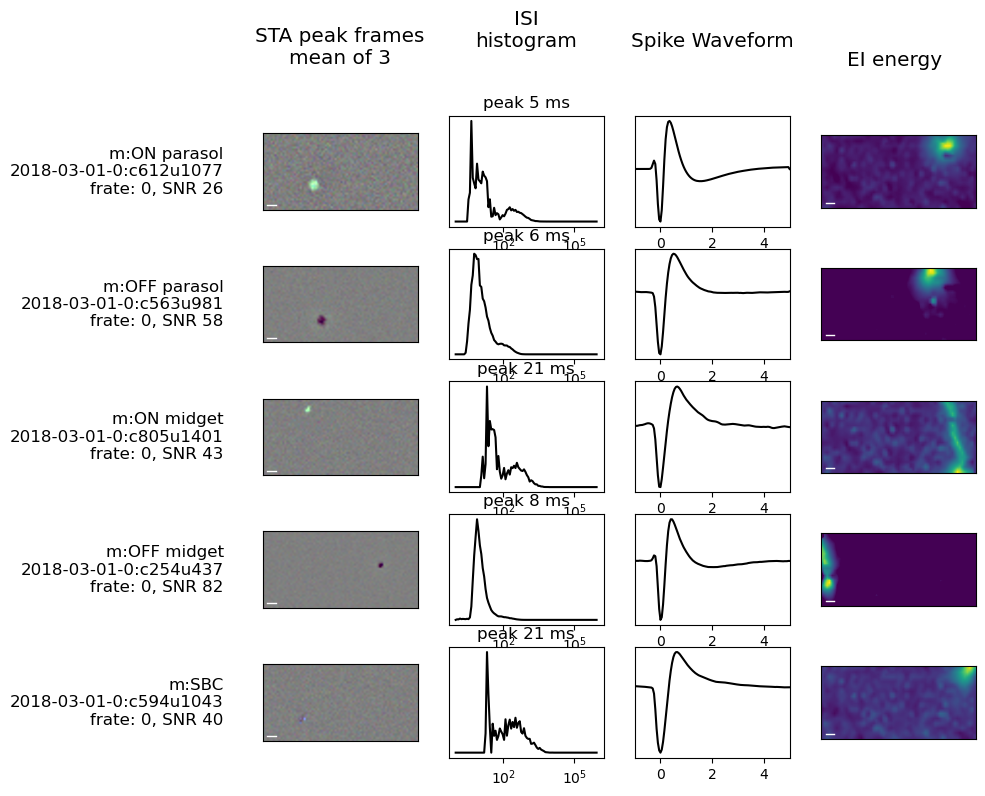

In [23]:
indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1, datasets=[0])
plots = [ 'acf','ei_map','spike_waveform']
fig, axs = ct.show_cell_grid(indices, plots=plots,
                             zoom_span=1000,
                             enable_zoom=False)

## FEATURE: Map EI Energy Early Characteristics

In [24]:
# Takes a min to run, put in print countdown in future updates
class Feature_map_early_ei_char(features.Feature):
    name = 'map_early_ei_char'
    requires = {'unit':{'map_ei_energy_early'}}
    provides = {'unit':{'total_energy_ptnorm','early_area','early_peri','early_circularity','early_centroid','soma_area','soma_peri','soma_circularity','soma_centroid'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Maddy' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return
        
        total_energy_ptnorm = []
        early_area = []
        early_peri = []
        early_circularity = []
        early_centroid = []
        soma_area = []
        soma_peri = []
        soma_circularity = []
        soma_centroid = []

        for ci in unit_indices:
            ei_energy= dtab.at[ci,'map_ei_energy_early'].a
            
            # Find Total Energy
            total_energy = np.sum(ei_energy.flatten()) / (ei_energy.shape[0]*ei_energy.shape[1])
            total_energy_ptnorm.append(total_energy)

            # Next Find Contours
            ei_energy = np.flip(ei_energy)
            thresholds = (np.percentile(ei_energy,90), np.percentile(ei_energy,99.8))
            ei_energy = np.flip(ei_energy)
            segments_all_ei = [measure.find_contours(ei_energy, level = thresholds[i]) for i in range(len(thresholds))]
            
            for ssi, segments in enumerate(segments_all_ei):
                if ssi==0:
                    for si, seg in enumerate(segments):
                        if si == 0:
                            
                            ## Set up for cv2
                            seg_proc = []
                            for point in seg:
                                point_proc = [int(point[0]), int(point[1])]
                                seg_proc.append([point_proc])
                            seg_proc = np.array(seg_proc)
                            
                            ## FIND EARLY AREA
                            early_a = cv2.contourArea(seg_proc)
                            if math.isnan(early_a):
                                early_a = 0.0
                            early_area.append(early_a)

                            ## FIND EARLY PERIMETER
                            early_p = cv2.arcLength(seg_proc,True)
                            if math.isnan(early_p):
                                early_p = 0.0
                            early_peri.append(early_p)

                            ## FIND EARLY CENTROID
                            M = cv2.moments(seg_proc)
                            if M['m00']==0.0:
                                cx = 0
                                cy = 0
                            else:
                                cx = int(M['m10']/M['m00'])
                                cy = int(M['m01']/M['m00'])
                            early_cen = [cx, cy]
                            early_centroid.append(file_handling.wrapper(early_cen))
                            
                            ## FIND EARLY CIRCULARITY
                            if early_a != 0 and early_p != 0:
                                early_cir = (4*np.pi*early_a) / (early_p**2)
                            else:
                                early_cir = 0.0
                            early_circularity.append(early_cir)


                if ssi==1:
                    for si, seg in enumerate(segments):
                        
                        ## Set up for cv2
                        if si == 0:
                            seg_proc = []
                            for point in seg:
                                point_proc = [int(point[0]), int(point[1])]
                                seg_proc.append([point_proc])
                            seg_proc = np.array(seg_proc)
                            
                            ## FIND SOMA AREA
                            soma_a = cv2.contourArea(seg_proc)
                            if math.isnan(soma_a):
                                soma_a = 0.0
                            soma_area.append(soma_a)

                            ## FIND SOMA PERIMETER
                            soma_p = cv2.arcLength(seg_proc,True)
                            if math.isnan(soma_p):
                                soma_p = 0.0
                            soma_peri.append(soma_p)

                            ## FIND SOMA CENTROID
                            M = cv2.moments(seg_proc)
                            if M['m00']==0.0:
                                cx = 0
                                cy = 0
                            else:
                                cx = int(M['m10']/M['m00'])
                                cy = int(M['m01']/M['m00'])
                            soma_cen = [cx, cy]
                            soma_centroid.append(file_handling.wrapper(soma_cen))

                            ## FIND SOMA CIRCULARITY
                            if soma_a != 0 and soma_p != 0:
                                soma_cir = (4*np.pi*soma_a) / (soma_p**2)
                            else:
                                soma_cir = 0.0
                            soma_circularity.append(soma_cir)
     
            
        dtab.loc[unit_indices,'total_energy_ptnorm'] = total_energy_ptnorm
        dtab.loc[unit_indices,'early_area'] = early_area
        dtab.loc[unit_indices,'early_peri'] = early_peri
        dtab.loc[unit_indices,'early_centroid'] = early_centroid
        dtab.loc[unit_indices,'early_circularity'] = early_circularity
        dtab.loc[unit_indices,'soma_area'] = soma_area
        dtab.loc[unit_indices,'soma_peri'] = soma_peri
        dtab.loc[unit_indices,'soma_centroid'] = soma_centroid
        dtab.loc[unit_indices,'soma_circularity'] = soma_circularity

        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_map_early_ei_char],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# We'll add a column to the cell grid figure to see how it looks on a per-cell basis
# use the returned axs variable to add your plots
# Check that it is working
# indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1, datasets=[0])
# for ind in indices:
#     cell = ct.get_cell(ind)
#     print(cell['total_energy_ptnorm'],cell['early_area'],cell['early_peri'],cell['early_centroid'].a, cell['early_circularity'],cell['soma_area'],cell['soma_peri'],cell['soma_centroid'].a,cell['soma_circularity'])


~ Activating per-dataset features ["<class '__main__.Feature_map_early_ei_char'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [map_early_ei_char] v0 by Maddy provides {'unit': {'early_peri', 'soma_peri', 'early_centroid', 'early_circularity', 'soma_centroid', 'soma_area', 'early_area', 'soma_circularity', 'total_energy_ptnorm'}}, requires {'unit': {'map_ei_energy_early'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 70 columns
*** elapsed 1s of 1s = 0.0m elapsed, of 0.0m estimated (1/2) (0.7 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [map_early_ei_char] v0 by Maddy provides {'unit': {'early_peri', 'soma_peri', 'early_centroid', 'early_circularity', 'soma_centroid', 'soma_area', 'early_area', 'soma_circularity', 'total_energy_ptnorm'}}, requires {'unit': {'map_ei_energy_early'}}
~ ... feature complete.

In [20]:
#Test retinal eccentricity
ct.dataset_table.drop(columns='location_eccentricity')
ct.unit_table.drop(['retinal_eccentricity'],axis=1)
display(ct.dataset_table)

KeyError: 'location_eccentricity'

## FEATURE: Retinal Eccentricity

In [25]:
# Takes a min to run, put in print countdown in future updates
class Feature_retinal_eccentricity(features.Feature):
    name = 'retinal_eccentricity'
    requires = {'dataset':set(),'unit':set()}
    provides = {'unit':{'retinal_eccentricity'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Maddy' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return
        
        piece_id = ct.dataset_table.loc[di,'piece_id']
        run_id = ct.dataset_table.loc[di,'run_id']
        if 'location_eccentricity' in ct.dataset_table.columns:
            dtab.loc[unit_indices,'retinal_eccentricity']=ct.dataset_table.location_eccentricity[str(piece_id)][str(run_id)]
        else:
            dtab.loc[unit_indices,'retinal_eccentricity']=100 #Unknown
        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_retinal_eccentricity],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# We'll add a column to the cell grid figure to see how it looks on a per-cell basis
# use the returned axs variable to add your plots
# Check that it is working
indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1)
eccentricity = []
for ind in indices:
    print(ind)
    cell = ct.get_cell(ind)
    cell_ecc = cell['retinal_eccentricity']
    eccentricity.append(cell_ecc)
print(eccentricity)

~ Activating per-dataset features ["<class '__main__.Feature_retinal_eccentricity'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [retinal_eccentricity] v0 by Maddy provides {'unit': {'retinal_eccentricity'}}, requires {'dataset': set(), 'unit': set()}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 71 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (1/2) (141.9 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [retinal_eccentricity] v0 by Maddy provides {'unit': {'retinal_eccentricity'}}, requires {'dataset': set(), 'unit': set()}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 71 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (2/2) (122.9 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
*** elapsed 0s of 0s = 0.0m elapsed
~ no overall 

In [12]:
ct.unit_table

unit_id           dataset_id run_id  \
piece_id     run_id unit_id                                        
2017-03-15-1 000    1              1  (2017-03-15-1, 000)    000   
                    4              4  (2017-03-15-1, 000)    000   
                    5              5  (2017-03-15-1, 000)    000   
                    6              6  (2017-03-15-1, 000)    000   
                    7              7  (2017-03-15-1, 000)    000   
...                              ...                  ...    ...   
2018-03-01-0 000    1665        1665  (2018-03-01-0, 000)    000   
                    1666        1666  (2018-03-01-0, 000)    000   
                    1667        1667  (2018-03-01-0, 000)    000   
                    1668        1668  (2018-03-01-0, 000)    000   
                    1669        1669  (2018-03-01-0, 000)    000   

                                 piece_id  valid label_manual_text_input  \
piece_id     run_id unit_id                                                
2017-03-15-1 000    1        2017-03-15-1   True              OFF midget   
                    4        2017-03-15-1   True               ON midget   
                    5        2017-03-15-1   True              OFF midget   
                    6        2017-03-15-1   True              ON parasol   
                    7        2017-03-15-1   True                     NaN   
...                                   ...    ...                     ...   
2018-03-01-0 000    1665     2018-03-01-0   True                    edge   
                    1666     2018-03-01-0   True                    edge   
                    1667     2018-03-01-0   True                    edge   
                    1668     2018-03-01-0   True              ON parasol   
                    1669     2018-03-01-0   True             OFF parasol   

                             alex_id spike_times  spike_count  spike_duration  \
piece_id     run_id unit_id                                                     
2017-03-15-1 000    1            0.0       a4550       4550.0      1797.35910   
                    4            1.0       a6743       6743.0      1799.72895   
                    5            2.0       a2876       2876.0      1796.27165   
                    6            3.0       a5747       5747.0      1799.87180   
                    7            NaN         a42         42.0      1712.65550   
...                              ...         ...          ...             ...   
2018-03-01-0 000    1665       909.0       a5845       5845.0      1799.67995   
                    1666       910.0       a1744       1744.0      1799.72620   
                    1667       219.0       a6145       6145.0      1799.95705   
                    1668       165.0       a5233       5233.0      1799.44105   
                    1669       131.0       a2060       2060.0      1796.87245   

                             ...  rf_threshold rf_size rf_num_islands  \
piece_id     run_id unit_id  ...                                        
2017-03-15-1 000    1        ...            a6      a7             a6   
                    4        ...            a6      a7             a6   
                    5        ...            a6      a7             a6   
                    6        ...            a6      a7             a6   
                    7        ...            a6      a7             a6   
...                          ...           ...     ...            ...   
2018-03-01-0 000    1665     ...            a6      a7             a6   
                    1666     ...            a6      a7             a6   
                    1667     ...            a6      a7             a6   
                    1668     ...            a6      a7             a6   
                    1669     ...            a6      a7             a6   

                            rf_solidity rf_size_hull  \
piece_id     run_id unit_id                            
2017-03-15-1 000    1                a7

## FEATURE: Axon Conduction Velocity

In [26]:
# Takes a min to run, put in print countdown in future updates
class Feature_axon_vel(features.Feature):
    name = 'axon_vel'
    requires = {'unit':{'ei'}}
    provides = {'unit':{'axon_vel'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Maddy' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return
        
        velocity = []

        for ci in unit_indices:
            ei = dtab.at[ci,'ei'].a
            vel = get_axonal_conduction_velocity(ei,10,60,6,10)
            if math.isnan(vel):
                vel = 0.0
            velocity.append(vel)


        dtab.loc[unit_indices,'axon_vel'] = velocity

        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_axon_vel],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# We'll add a column to the cell grid figure to see how it looks on a per-cell basis
# use the returned axs variable to add your plots
# Check that it is working
# indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1, datasets=[0])
# velocity = []
# for ind in indices:
#     print(ind)
#     cell = ct.get_cell(ind)
#     vel = cell['axon_vel']
#     velocity.append(vel)
# print(velocity)

~ Activating per-dataset features ["<class '__main__.Feature_axon_vel'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [axon_vel] v0 by Maddy provides {'unit': {'axon_vel'}}, requires {'unit': {'ei'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 72 columns
*** elapsed 47s of 47s = 0.8m elapsed, of 1.6m estimated (1/2) (0.0 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [axon_vel] v0 by Maddy provides {'unit': {'axon_vel'}}, requires {'unit': {'ei'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 72 columns
*** elapsed 46s of 93s = 1.5m elapsed, of 1.5m estimated (2/2) (0.0 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
*** elapsed 0s of 93s = 1.5m elapsed
~ no overall features are enabled
*** elapsed 0s of 93s = 1.5m elapsed
~ 
All done generating features! Co

## FEATURE: ACF Power Spectrum ##

~ Activating per-dataset features ["<class '__main__.Feature_spec_acf'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [spec_acf] v0 by Mads provides {'unit': {'spec_timeoverlap_acf', 'spec_acf', 'spec_freq_acf'}}, requires {'unit': {'acf'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 75 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (1/2) (4.9 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [spec_acf] v0 by Mads provides {'unit': {'spec_timeoverlap_acf', 'spec_acf', 'spec_freq_acf'}}, requires {'unit': {'acf'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 75 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (2/2) (4.5 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
*** elapsed 0s of 0s = 0.0m elapsed
~ no overall features are ena

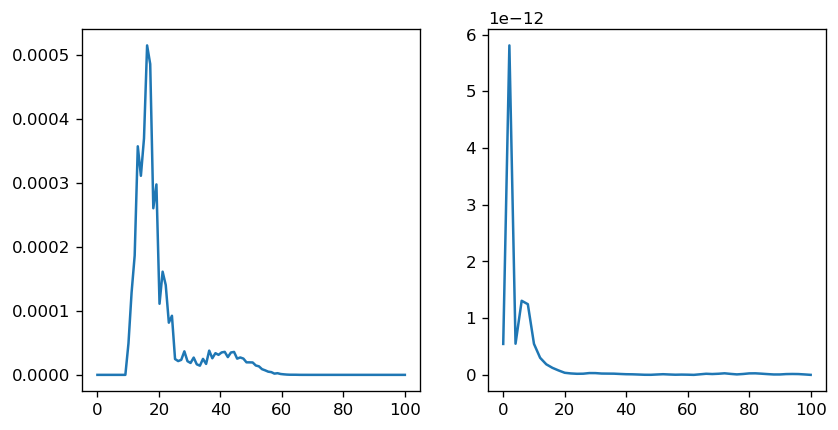

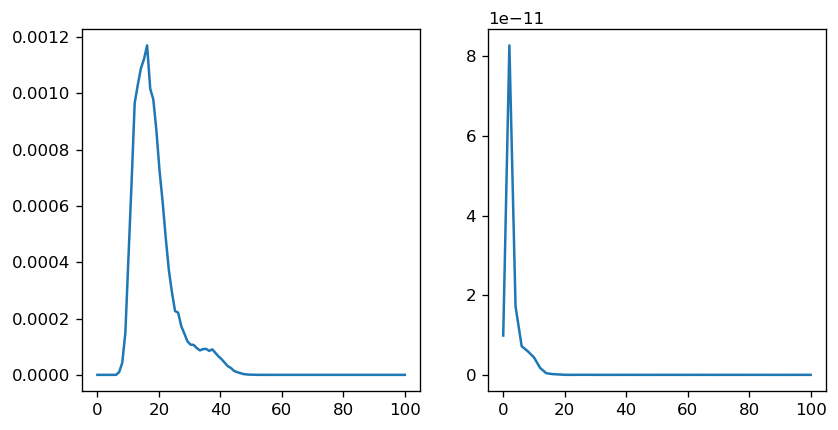

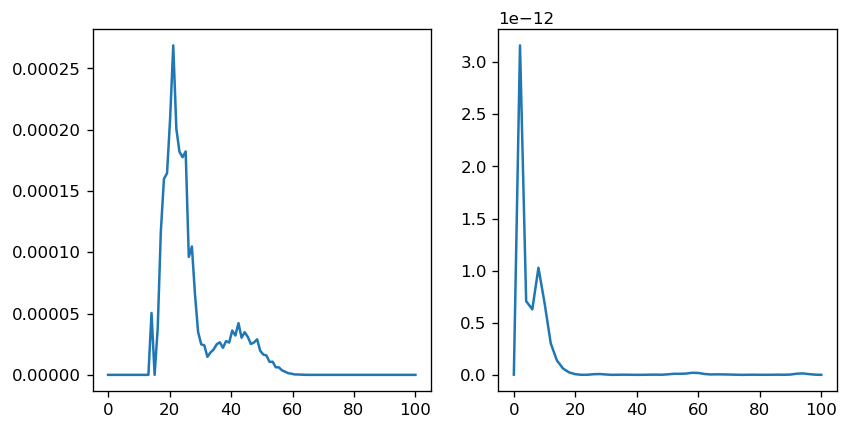

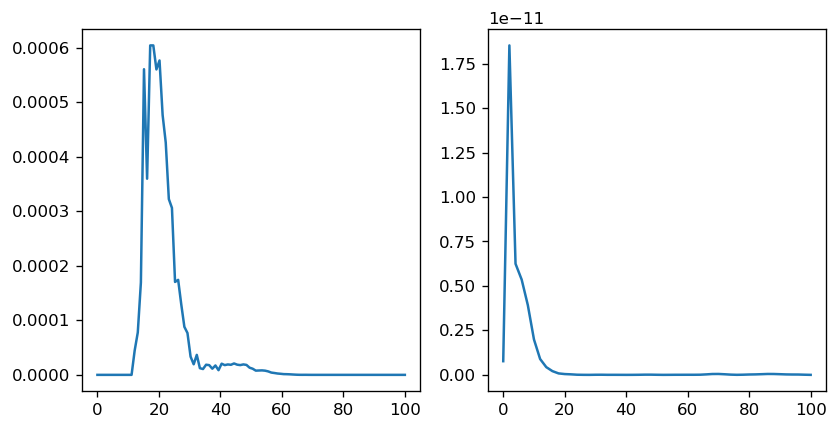

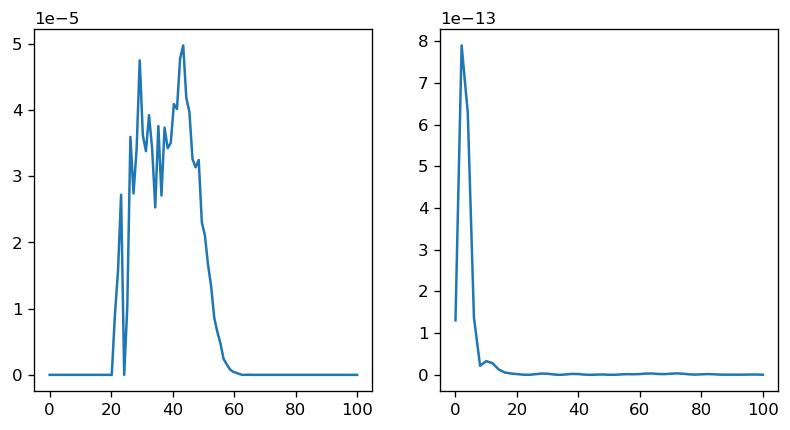

In [27]:
# Let's say we have a project in which we think the spike rate plus the 1/2 the EI peak value will help us tell apart cell types
# we'll call this our "new_idea" which is a bad descriptive name
# We'll make a feature to generate this new column (although of course it's trivial)

# Why not just make a column in the ct.unit_table manually? Well, you could, but Features offer more utility,
# such as requirements checking and inter-person portability. Eventually, you'll be able to request columns and the
# features will be automatically selected to generate it
# import file_handling
# import features

class Feature_spec_acf(features.Feature):
    name = 'spec_acf'
    # NOTE: This is assuming ISI is being calculated from spike times (generate_acf_from_spikes)
    requires = {'unit':{'acf'}}
    provides = {'unit':{'spec_acf','spec_freq_acf','spec_timeoverlap_acf'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Mads' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return
        
        spec = []
        f = []
        t = []

        for ci in unit_indices:
            wave = dtab.at[ci,'acf'].a
        
            t_wave = np.arange(len(wave)) / 20 - 5
            t_wave = t_wave / 1000
            fs = 20000


            n = min(256,len(wave))
            f2, t2, spec2 = spectrogram(wave, nperseg = n, fs=fs, window = ('hanning'), noverlap=np.ceil(n/2))
            spec.append(file_handling.wrapper(spec2))
            f.append(file_handling.wrapper(f2))
            # t.append(file_handling.wrapper(t2))
            t.append(t2)

        dtab.loc[unit_indices,'spec_acf'] = spec
        dtab.loc[unit_indices,'spec_freq_acf'] = f
        dtab.loc[unit_indices,'spec_timeoverlap_acf'] = t

        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_spec_acf],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# # Check that it is working
indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1, datasets=[0])
cnt = 1
for ind in indices:
    print(ind)
    cell = ct.get_cell(ind)
    print(cell)

    wave = cell['acf'].a

    plt.figure(cnt)
    plt.subplot(1,2,1)
    plt.plot(np.linspace(0,100,100),wave)
    
    plt.subplot(1,2,2)
    plt.plot(np.linspace(0,100,51),cell['spec_acf'].a)
    cnt += 1

## FEATURE: Spike Waveform Power Spectrum ##

In [29]:
# Let's say we have a project in which we think the spike rate plus the 1/2 the EI peak value will help us tell apart cell types
# we'll call this our "new_idea" which is a bad descriptive name
# We'll make a feature to generate this new column (although of course it's trivial)

# Why not just make a column in the ct.unit_table manually? Well, you could, but Features offer more utility,
# such as requirements checking and inter-person portability. Eventually, you'll be able to request columns and the
# features will be automatically selected to generate it
# import file_handling

class Feature_spec_spike_waveform(features.Feature):
    name = 'spec_spike_waveform'
    requires = {'unit':{'spike_waveform_maxamplitude'}}
    provides = {'unit':{'spec_spike_waveform','spec_freq','spec_timeoverlap'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Mads' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return
        
        spec = []
        f = []
        t = []

        for ci in unit_indices:
            wave = dtab.at[ci,'spike_waveform_maxamplitude'].a
        
            t_wave = np.arange(len(wave)) / 20 - 5
            t_wave = t_wave / 1000
            fs = 20000


            n = min(256,len(wave))
            f2, t2, spec2 = spectrogram(wave, nperseg = n, fs=fs, window = ('hanning'), noverlap=np.ceil(n/2))
            spec.append(file_handling.wrapper(spec2))
            f.append(file_handling.wrapper(f2))
            t.append(file_handling.wrapper(t2))

        dtab.loc[unit_indices,'spec_spike_waveform'] = spec
        dtab.loc[unit_indices,'spec_freq'] = f
        dtab.loc[unit_indices,'spec_timeoverlap'] = t

        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_spec_spike_waveform],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# Check that it is working
# indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','ON midget','OFF midget','SBC'], count_each_type=1, datasets=[0])
# cnt = 1
# for ind in indices:
#     print(ind)
#     cell = ct.get_cell(ind)
#     print(cell)

#     wave = cell['spike_waveform_maxamplitude'].a
#     t_wave = np.arange(len(wave)) / 20 - 5
#     t_wave = t_wave / 1000
#     fs = 20000
#     dt = 1/20000

#     plt.figure(cnt)
#     plt.subplot(1,2,1)
#     plt.plot(t_wave,wave)
    
#     plt.subplot(1,2,2)
#     plt.plot(np.linspace(-0.005,0.005,101),cell['spec_spike_waveform'].a)
#     cnt += 1

~ Activating per-dataset features ["<class '__main__.Feature_spec_spike_waveform'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [spec_spike_waveform] v0 by Mads provides {'unit': {'spec_freq', 'spec_timeoverlap', 'spec_spike_waveform'}}, requires {'unit': {'spike_waveform_maxamplitude'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 78 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (1/2) (4.5 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [spec_spike_waveform] v0 by Mads provides {'unit': {'spec_freq', 'spec_timeoverlap', 'spec_spike_waveform'}}, requires {'unit': {'spike_waveform_maxamplitude'}}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 78 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (2/2) (4.1 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:

## FEATURE: Piece ID & Run ID into Integer ##

In [30]:
# Let's say we have a project in which we think the spike rate plus the 1/2 the EI peak value will help us tell apart cell types
# we'll call this our "new_idea" which is a bad descriptive name
# We'll make a feature to generate this new column (although of course it's trivial)

# Why not just make a column in the ct.unit_table manually? Well, you could, but Features offer more utility,
# such as requirements checking and inter-person portability. Eventually, you'll be able to request columns and the
# features will be automatically selected to generate it

class Feature_int_piece_id(features.Feature):
    name = 'int_piece_id'
    requires = {'dataset':set(),'unit':set()}
    provides = {'unit':{'int_piece_id','int_run_id'}}
    input = set()
    version = 0 # eventually, we'll track these to keep values in sync
    maintainer = 'Mads' # so we can blame you when it goes wrong and praise you when it's great

    def generate(self, ct, unit_indices, inpt, dtab=None):
        if dtab is None:
            dtab = ct.unit_table
        di = unit_indices[0][0:2]
        if (missing := self.check_requirements(ct, di)) is not None:
            print('Feature {}: missing requirements {}'.format(self.name, missing))
            return

        piece_id = ct.dataset_table.loc[di,'piece_id']
        run_id = ct.dataset_table.loc[di,'run_id']
        compString = piece_id.replace('-','')
        dtab.loc[unit_indices, 'int_piece_id'] = int(compString)
        dtab.loc[unit_indices, 'int_run_id'] = int(run_id)
        

        # mark these columns as valid
        self.update_valid_columns(ct, di)


ct.generate_features(features_to_activate_per_dataset=[Feature_int_piece_id],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

# We'll add a column to the cell grid figure to see how it looks on a per-cell basis
# use the returned axs variable to add your plots
# indices = ct.cell_selection_examples(types=['ON parasol','OFF parasol','SBC'], count_each_type=1, datasets=[0])

# Check that it is working
# for ind in indices:
#     print(ind)
#     cell = ct.get_cell(ind)
#     # print(cell)
#     print(cell['int_piece_id'])


~ Activating per-dataset features ["<class '__main__.Feature_int_piece_id'>"]
*** timer  started
~ 

Generating features for dataset ('2017-03-15-1', '000'), 1 of 2
~ Feature: [int_piece_id] v0 by Mads provides {'unit': {'int_run_id', 'int_piece_id'}}, requires {'dataset': set(), 'unit': set()}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 80 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (1/2) (135.4 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
~ 

Generating features for dataset ('2018-03-01-0', '000'), 2 of 2
~ Feature: [int_piece_id] v0 by Mads provides {'unit': {'int_run_id', 'int_piece_id'}}, requires {'dataset': set(), 'unit': set()}
~ ... feature complete. unit_table has 1995 (1962 valid) entries, with 80 columns
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (2/2) (133.3 / sec)
.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:._.:*~*:.
*** elapsed 0s of 0s = 0.0m elapsed
~ no overall features are e

In [61]:
# Now test the python
import features_DLelec as feat_dl
ct.generate_features(features_to_activate_per_dataset=[Feature_int_piece_id],
                     force_features=True,
                     ignore_errors=False,
                     load_analysis_data=False)

ModuleNotFoundError: No module named 'features_DLelec'

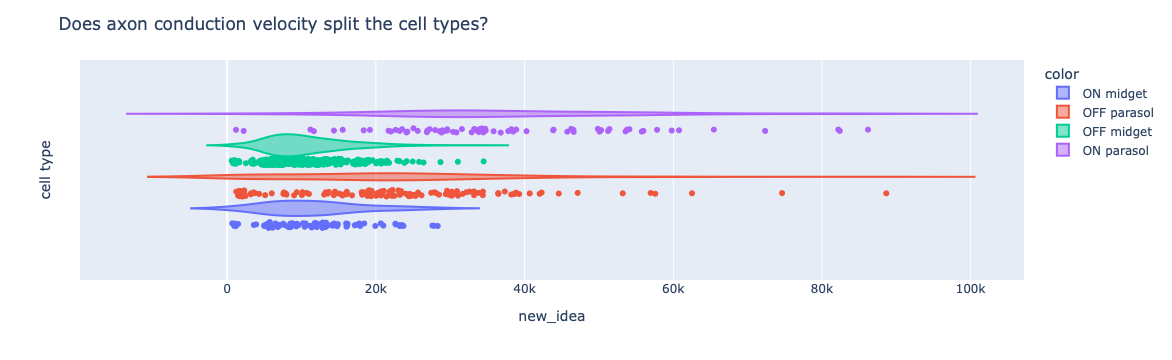

In [126]:
# Now let's see how it looks across the population
# I'm using a violin plot from plotly express, another very useful tool


indices = ct.cell_selection(types=['ON parasol','OFF parasol','ON midget','OFF midget'], pieces=[0])
cells = ct.get_cells(indices)
axon_vel = cells.spike_area2.to_numpy()

fig = px.violin(axon_vel, x=0, points='all',color=cells.label_manual_text, hover_name=cells.index.to_numpy())
fig.update_layout({'title': 'Does axon conduction velocity split the cell types?', 'xaxis_title':'new_idea', 'yaxis_title':'cell type'})
fig.show()

# Nope! That's terrible. Time to find a new project idea.

In [ ]:
# this function will save the units, cells, and dataset_table row in its own table, which everyone shares (unless you use a
# different file_root argument, which you should if you are making weird tables)
# the save_name argument is specific to you and this project, always, and saves your dataset_table in a
# single file so you can easily reload the whole set of datasets
save_file = 1

if save_file:
    ct.file_save_pieces(save_name=save_name, file_root=scratch_file_root)
else:
    print('NO SAVE')